<a href="https://colab.research.google.com/github/J-Ayaan/Intelligent_SW/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 990551.77it/s] 


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133347.38it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1081649.46it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2787610.30it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Epoch [1/10], Loss: 0.004999495577067137


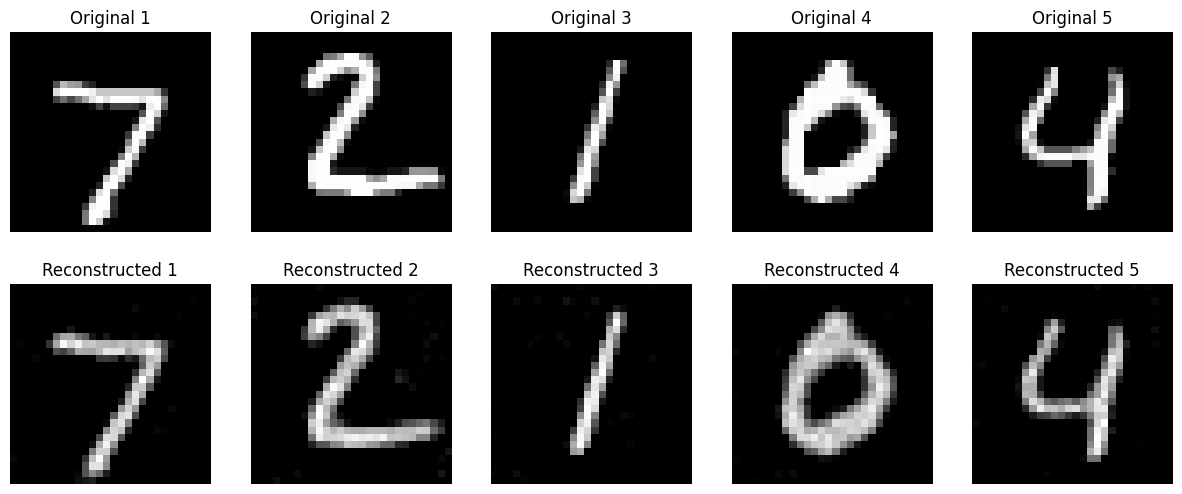

Test Loss after epoch 1: 0.004761
Epoch [2/10], Loss: 0.0029420636128634214


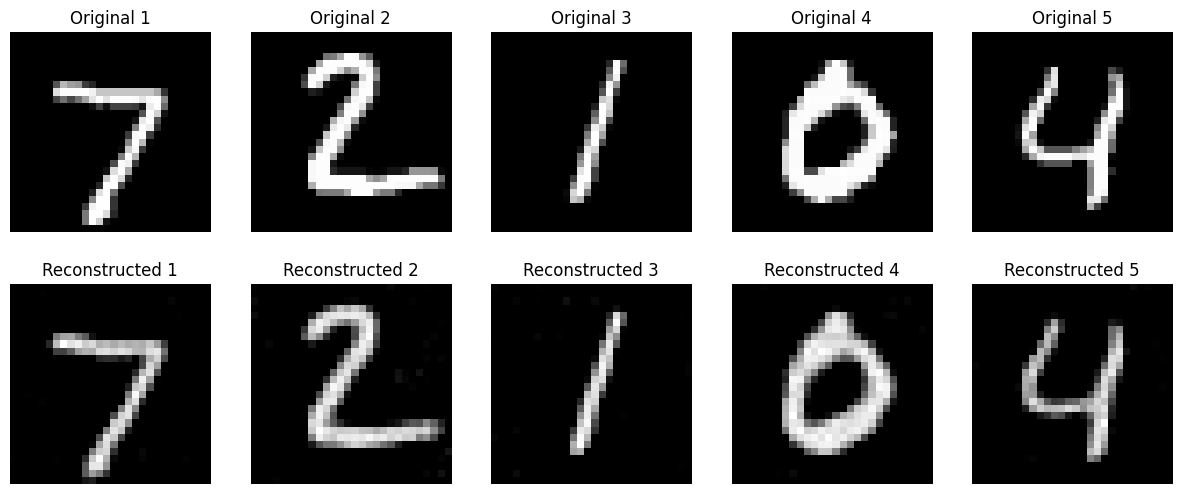

Test Loss after epoch 2: 0.002736
Epoch [3/10], Loss: 0.0020788784604519606


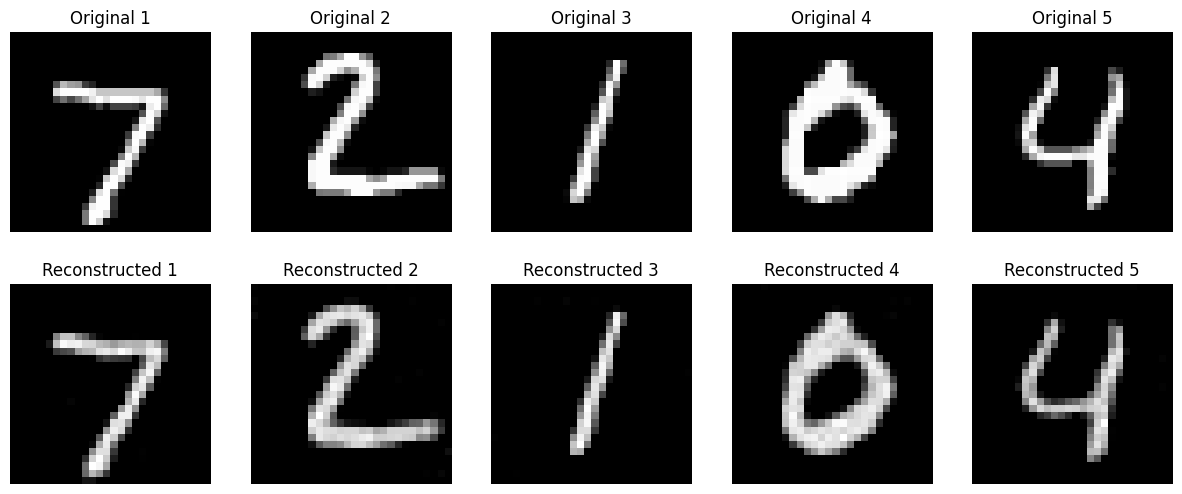

Test Loss after epoch 3: 0.002242
Epoch [4/10], Loss: 0.0017197612905874848


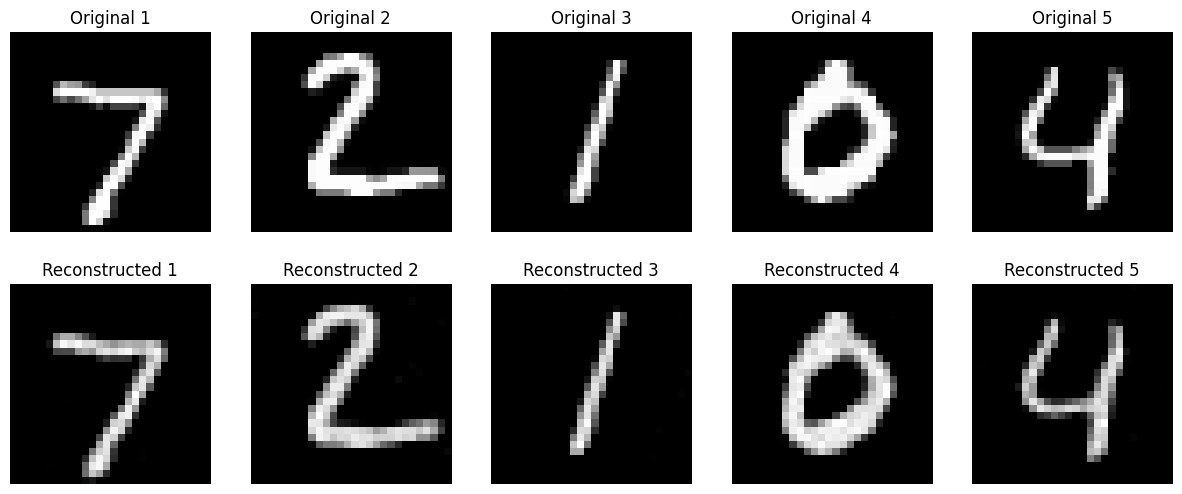

Test Loss after epoch 4: 0.001774
Epoch [5/10], Loss: 0.0015121586620807648


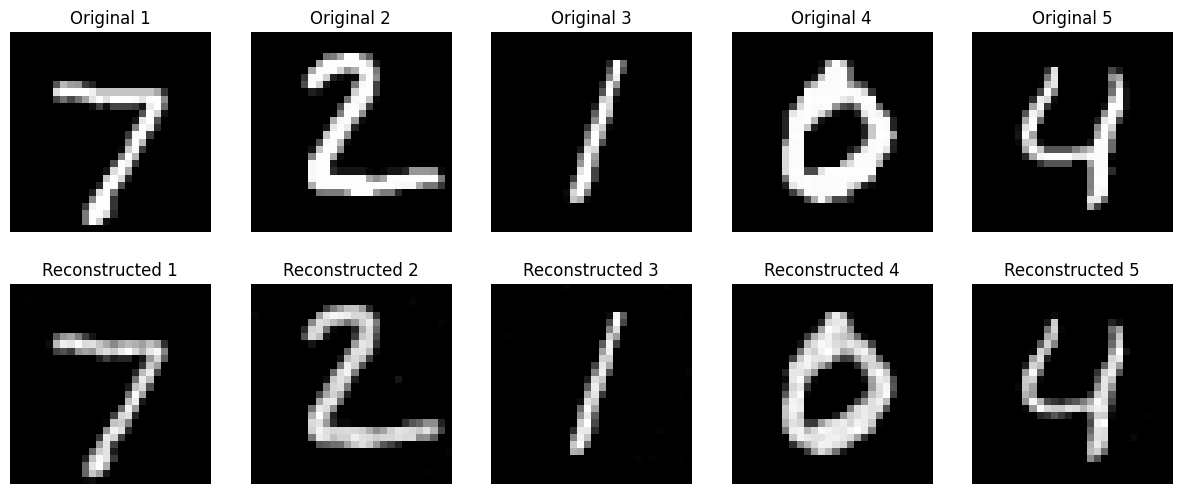

Test Loss after epoch 5: 0.001930
Epoch [6/10], Loss: 0.0013315342366695404


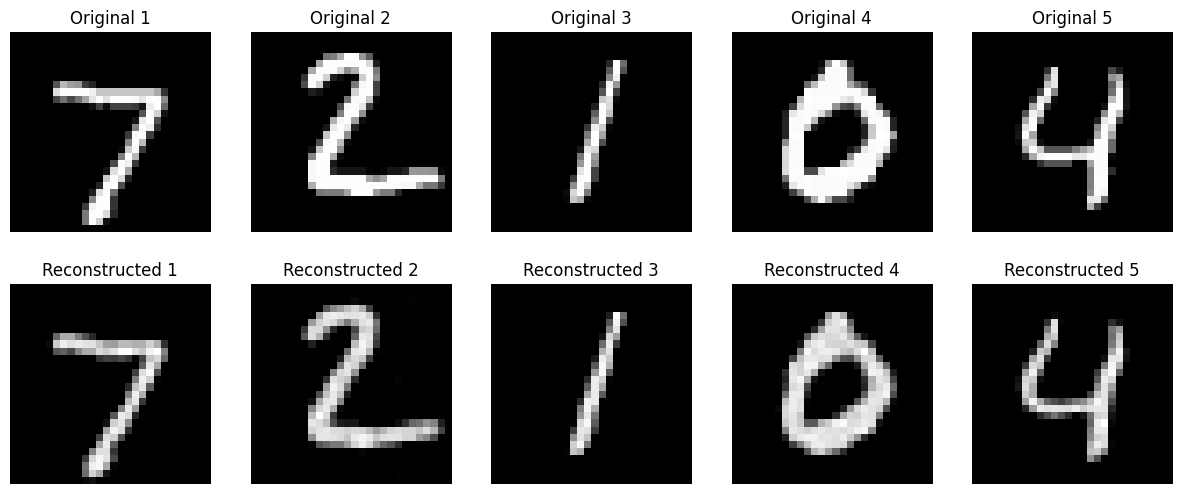

Test Loss after epoch 6: 0.001393
Epoch [7/10], Loss: 0.0012495866976678371


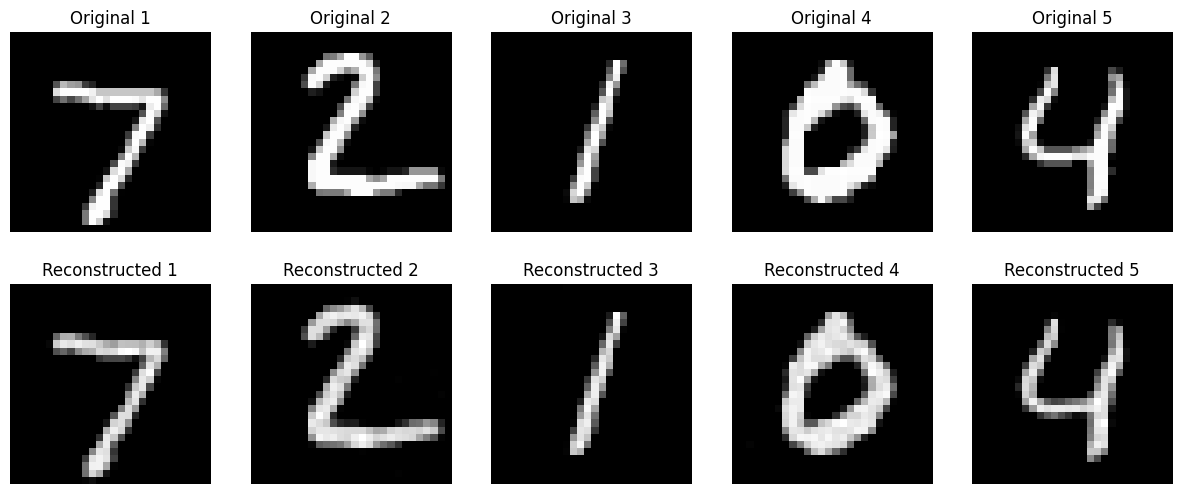

Test Loss after epoch 7: 0.001244
Epoch [8/10], Loss: 0.001179790124297142


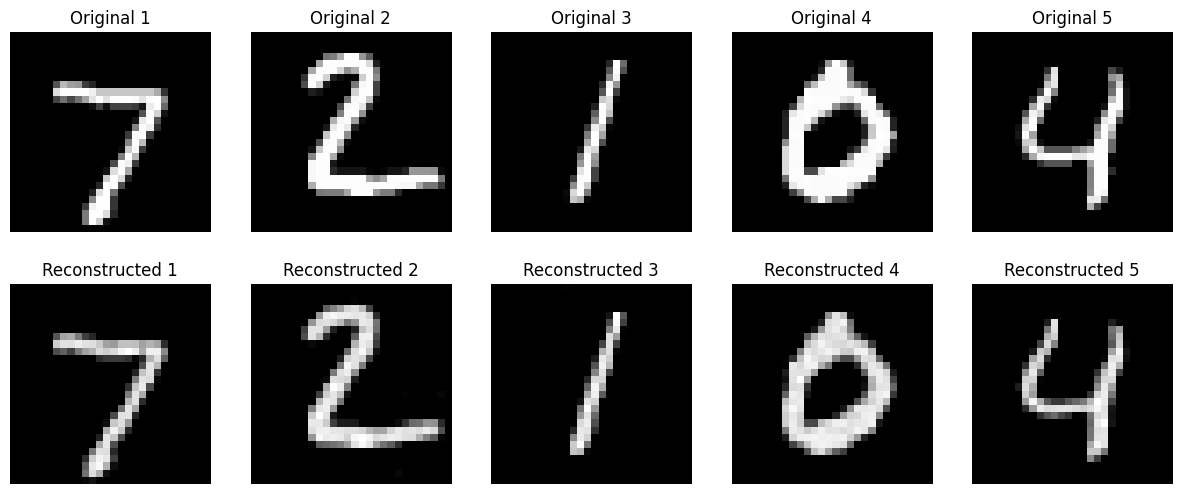

Test Loss after epoch 8: 0.001001
Epoch [9/10], Loss: 0.0010774832917377353


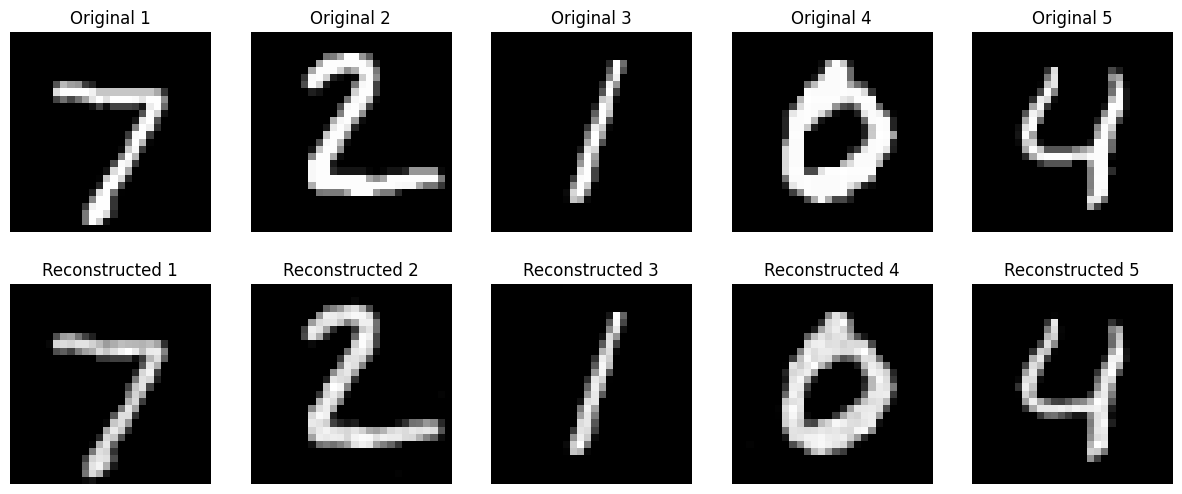

Test Loss after epoch 9: 0.001028
Epoch [10/10], Loss: 0.000827366195153445


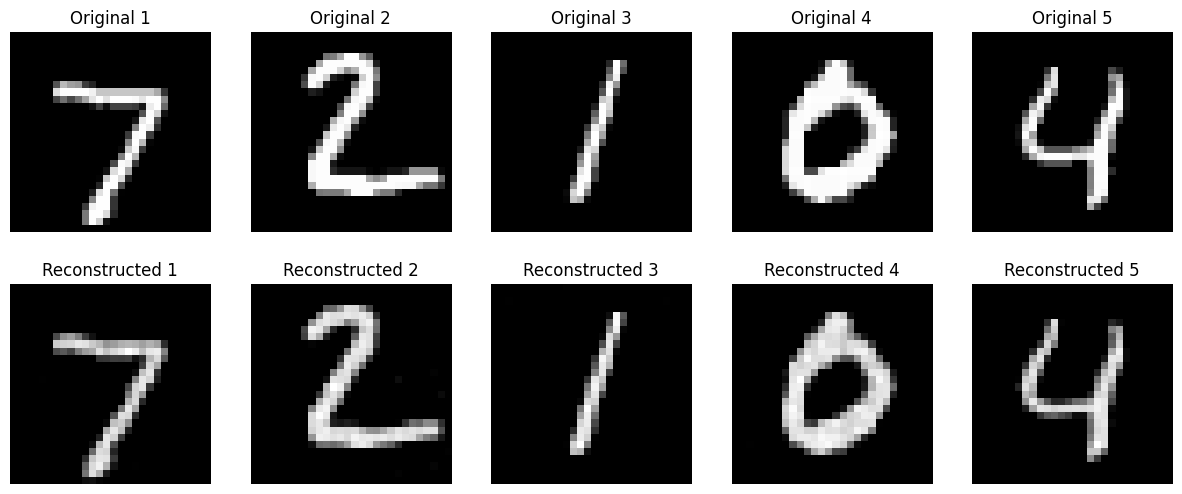

Test Loss after epoch 10: 0.000901


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

# 인코더 클래스 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),  # 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),  # 64 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)  # 64 x 14 x 14 (맥스 풀링을 통해 사이즈 절반 감소)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128 x 7 x 7
            nn.Conv2d(128, 256, 3, padding=1),  # 256 x 7 x 7
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)  # 배치를 펼쳐서 벡터 형태로 변환
        return out

# 디코더 클래스 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),  # 128 x 14 x 14 (업샘플링)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),  # 64 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),  # 16 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),  # 1 x 28 x 28 (최종 복원된 이미지)
            nn.ReLU()
        )

    def forward(self, x):
        out = x.view(batch_size, 256, 7, 7)  # 입력을 다시 7x7 이미지로 변환
        out = self.layer1(out)
        out = self.layer2(out)
        return out

# MNIST 데이터셋 로드
mnist_train = dset.MNIST("./data/MNIST", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./data/MNIST", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 100
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

num_epoch = 10
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)  # 인코더를 CUDA로 이동
decoder = Decoder().to(device)  # 디코더를 CUDA로 이동

parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()  # 손실 함수: MSE(평균 제곱 오차)
optimizer = torch.optim.Adam(parameters, lr=learning_rate)  # 옵티마이저: Adam

# 학습 루프
for epoch in range(num_epoch):
    encoder.train()  # 인코더를 학습 모드로 설정
    decoder.train()  # 디코더를 학습 모드로 설정

    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)  # 이미지를 CUDA로 이동
        z = encoder(image)  # 인코더를 통해 잠재 벡터 추출
        output = decoder(z)  # 디코더를 통해 이미지를 재구성
        loss = loss_func(output, image)  # 원본 이미지와의 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝 수행
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.cpu().item()}")  # 학습 중 손실 출력

    # 각 에폭 후 모델 테스트
    encoder.eval()  # 인코더를 평가 모드로 설정
    decoder.eval()  # 디코더를 평가 모드로 설정

    test_loss = 0
    with torch.no_grad():  # 테스트 중에는 역전파 계산 비활성화
        for j, [image, label] in enumerate(test_loader):
            image = image.to(device)
            z = encoder(image)
            output = decoder(z)
            loss = loss_func(output, image)
            test_loss += loss.item()

            # 각 에폭 후 5열로 이미지 출력
            if j == 0:  # 첫 번째 배치에서만 이미지를 출력
                out_img = torch.squeeze(output.cpu().data)
                fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2행 5열의 서브플롯 생성

                for i in range(5):
                    axes[0, i].imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')  # 원본 이미지 출력
                    axes[0, i].set_title(f"Original {i+1}")
                    axes[0, i].axis('off')

                    axes[1, i].imshow(out_img[i].numpy(), cmap='gray')  # 재구성된 이미지 출력
                    axes[1, i].set_title(f"Reconstructed {i+1}")
                    axes[1, i].axis('off')

                plt.show()

    # 테스트 손실 출력
    test_loss /= len(test_loader)
    print(f"Test Loss after epoch {epoch+1}: {test_loss:.6f}")
